In [44]:
from imports import *
from read_RVs import *
from bgls import *
from periodogram import compute_LSperiodogram, bootstrap_FAP
import matplotlib.gridspec as gridspec
%matplotlib inline

## get RV and transit data

In [38]:
# get RV and TESS data
Ms, Rs = unp.uarray(.621,.012), unp.uarray(.598,.018)  # Cloutier 2018
bjdT, f, ef = readdata_toi134_TESS()
bjdTbin, fbin, efbin = bin_data(bjdT, f, ef, dt=.2)
bjdH, rvH, ervH, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = readdata_toi134_HARPS()
bjdP, rvP, ervP, SKHP, HalphaP = readdata_toi134_PFSv2()
s = np.argsort(bjdP)
bjdP, rvP, ervP, SKHP, HalphaP = bjdP[s], rvP[s], ervP[s], SKHP[s], HalphaP[s]
print bjdTbin.size, bjdH.size, bjdP.size

138 47 76


In [39]:
# remove entries based on LOOCV
bH = np.delete(np.arange(bjdH.size), [37,42,44])
bP = np.delete(np.arange(bjdP.size), [71])
bjdH, rvH, ervH, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = \
bjdH[bH], rvH[bH], ervH[bH], Halpha[bH], eHalpha[bH], Hbeta[bH], eHbeta[bH], Hgamma[bH], eHgamma[bH], NaD[bH], \
eNaD[bH], Sindex[bH], eSindex[bH]
bjdP, rvP, ervP, SKHP, HalphaP = bjdP[bP], rvP[bP], ervP[bP], SKHP[bP], HalphaP[bP]
print bjdTbin.size, bjdH.size, bjdP.size

138 44 75


<Container object of 3 artists>

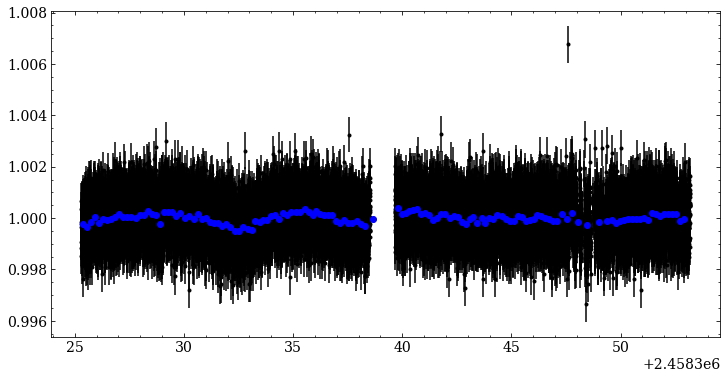

In [17]:
# plot light curve
plt.figure(figsize=(12,6))
plt.errorbar(bjdT, f, ef, fmt='k.', capsize=0)
plt.errorbar(bjdTbin, fbin, efbin, fmt='bo', capsize=0)
#theta = 1.40146, 2458326.0332, 5.29, .0243, 83.6, 0, 0, .36, .25
#phase = foldAt(bjdT, theta[0], theta[1])
#phase[phase>.5] -=1
#fmodel = transit_model(theta, bjdT)
#plt.plot(phase, f, '.', phase, fmodel, '.'), plt.xlim((-.1,.1))

Text(0,0.5,u'raw RV [m/s]')

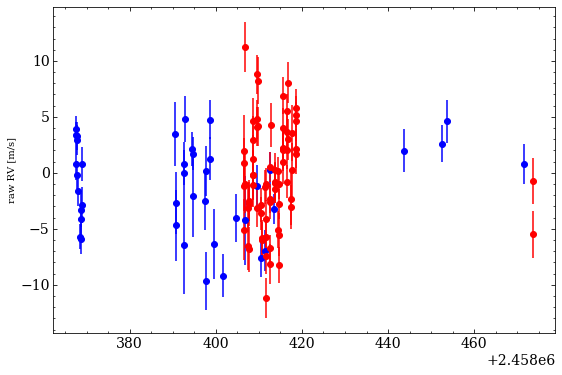

In [18]:
# plot RV time-series
plt.figure(figsize=(9,6))
plt.errorbar(bjdH, rvH, ervH, fmt='bo', capsize=0, label='HARPS')
plt.errorbar(bjdP, rvP, ervP, fmt='ro', capsize=0, label='PFS')
plt.ylabel('raw RV [m/s]')

## plot periodograms

In [40]:
def do_bootstrap(x, y, ey, plims, N):
    pwrs,faps,_,_ = bootstrap_FAP(x, y, ey, plims=plims, N=int(N), quiet=True)
    return faps, pwrs


def scale_err(rv, erv, arr):
    '''Derive uncertainties for an input timeseries based on the fractional RV uncertainties for use in periodogram
    calulations.'''
    return arr * erv / rv

In [51]:
# save bootstrap results
Hlen = bjdH.max()-bjdH.min()
Plen = bjdP.max()-bjdP.min()
Pb, Prot = 1.4013, 30.

save_bootstraps = 1
if save_bootstraps:
    
    # HARPS
    xH = [bjdH, bjdH, bjdH, bjdH, bjdH, bjdH, bjdH]
    yH = [rvH, bjdH, Halpha, Hbeta, Hgamma, NaD, Sindex]
    eyH = [ervH, np.ones(bjdH.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
    labelsH = ['HRV','HWF','HHalpha','HHbeta','HHgamma','HNaD','HSindex']
    for i in range(len(xH)):
        print i/float(len(xH))
        #faps, pwrs = do_bootstrap(xH[i], yH[i], eyH[i], (.5,Hlen), 1e4)
        #np.save('output_data/FAPS_%s'%labelsH[i], np.array([faps,pwrs]).T)
        
    # PFS
    xP = [bjdP, bjdP, bjdP, bjdP]
    yP = [rvP, bjdP, HalphaP, SKHP]
    eyP = [ervP, np.ones(bjdP.size), scale_err(rvP,ervP,HalphaP), scale_err(rvP,ervP,SKHP)]
    labelsP = ['PRV','PWF','PHalpha','PHK']
    for i in range(len(xP)):
        print i/float(len(xP))
        faps, pwrs = do_bootstrap(xP[i], yP[i], eyP[i], (.5,Plen), 1e4)
        np.save('output_data/FAPS_%s'%labelsP[i], np.array([faps,pwrs]).T)     

0.0
0.142857142857
0.285714285714
0.428571428571
0.571428571429
0.714285714286
0.857142857143
0.0
Computing FAPs from bootstrapping...
0.25
Computing FAPs from bootstrapping...
0.5
Computing FAPs from bootstrapping...
0.75
Computing FAPs from bootstrapping...


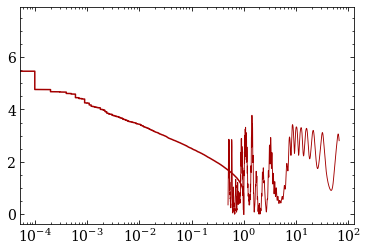

In [128]:
per,pwr,_ = compute_LSperiodogram(bjdP, rvP, ervP, plims=(.5,Plen))
normP = pwr.std()
plt.plot(per, pwr/normP, '-', c=colP, lw=.9)
faps, pwrs = np.load('output_data/FAPS_PRV.npy').T
plt.plot(faps, pwrs/normP, '-', c=colP)
plt.xscale('log')

In [130]:
per[pwr==pwr.max()]
fint = interp1d(pwrs,faps)
fint(pwr.max())*1e2

0.3

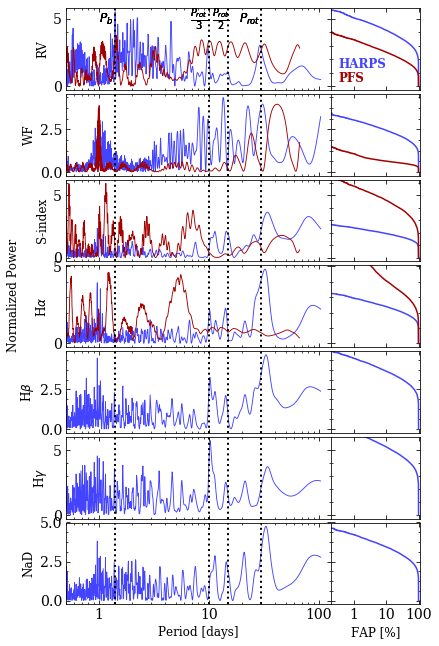

In [121]:
# plot periodograms
colH, colP = '#4444ff', '#a30000'
fig = plt.figure(figsize=(6,9))
gs = gridspec.GridSpec(7,4)

# RVs
ax11 = plt.subplot(gs[0,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, rvH, ervH, plims=(.5,Hlen))
normH = pwr.std()
ax11.plot(per, pwr/normH, '-', c=colH, lw=.9)
per,pwr,_ = compute_LSperiodogram(bjdP, rvP, ervP, plims=(.5,Plen))
normP = pwr.std()
ax11.plot(per, pwr/normP, '-', c=colP, lw=.9)
# RV faps
ax12 = plt.subplot(gs[0,-1])
faps, pwrs = np.load('output_data/FAPS_HRV.npy').T
ax12.plot(faps, pwrs/normH, '-', c=colH)
faps, pwrs = np.load('output_data/FAPS_PRV.npy').T
ax12.plot(faps, pwrs/normP, '-', c=colP)
# customize
ax12.set_xscale('log'), ax11.set_xscale('log')
ax12.set_xlim((2e-3,1.1)), ax11.set_xlim((.5,130))
ax12.set_ylim(ax11.get_ylim()), ax12.set_yticklabels('')
ax12.set_xticks(np.logspace(-2,0,3))
ax11.set_ylabel('RV', fontsize=12)
ax12.set_xticklabels(''), ax11.set_xticklabels('')

# WF
ax21 = plt.subplot(gs[1,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, bjdH, np.ones(bjdH.size), plims=(.5,Hlen))
normH = pwr.std()
ax21.plot(per, pwr/normH, '-', c=colH, lw=.9)
per,pwr,_ = compute_LSperiodogram(bjdP, bjdP, np.ones(bjdP.size), plims=(.5,Plen))
normP = pwr.std()
ax21.plot(per, pwr/normP, '-', c=colP, lw=.9)
# WF faps
ax22 = plt.subplot(gs[1,-1])
faps, pwrs = np.load('output_data/FAPS_HWF.npy').T
ax22.plot(faps, pwrs/normH, '-', c=colH)
faps, pwrs = np.load('output_data/FAPS_PWF.npy').T
ax22.plot(faps, pwrs/normP, '-', c=colP)
# customize
ax22.set_xscale('log'), ax21.set_xscale('log')
ax22.set_xlim((2e-3,1.1)), ax21.set_xlim((.5,130))
ax22.set_ylim(ax21.get_ylim()), ax22.set_yticklabels('')
ax22.set_xticks(np.logspace(-2,0,3))
ax21.set_ylabel('WF', fontsize=12)
ax22.set_xticklabels(''), ax21.set_xticklabels('')

# Halpha
ax31 = plt.subplot(gs[3,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, Halpha, eHalpha, plims=(.5,Hlen))
normH = pwr.std()
ax31.plot(per, pwr/normH, '-', c=colH, lw=.9)
per,pwr,_ = compute_LSperiodogram(bjdP, HalphaP, scale_err(rvP,ervP,HalphaP), plims=(.5,Plen))
normP = pwr.std()
ax31.plot(per, pwr/normP, '-', c=colP, lw=.9)
# WF faps
ax32 = plt.subplot(gs[3,-1])
faps, pwrs = np.load('output_data/FAPS_HHalpha.npy').T
ax32.plot(faps, pwrs/normH, '-', c=colH)
faps, pwrs = np.load('output_data/FAPS_PHalpha.npy').T
ax32.plot(faps, pwrs/normP, '-', c=colP)
# customize
ax32.set_xscale('log'), ax31.set_xscale('log')
ax32.set_xlim((2e-3,1.1)), ax31.set_xlim((.5,130))
ax32.set_ylim(ax31.get_ylim()), ax32.set_yticklabels('')
ax32.set_xticks(np.logspace(-2,0,3))
ax31.set_ylabel('H$\\alpha$', fontsize=12)
ax32.set_xticklabels(''), ax31.set_xticklabels('')

# S-index
ax41 = plt.subplot(gs[2,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, Sindex, eSindex, plims=(.5,Hlen))
normH = pwr.std()
ax41.plot(per, pwr/normH, '-', c=colH, lw=.9)
per,pwr,_ = compute_LSperiodogram(bjdP, SKHP, scale_err(rvP,ervP,SKHP), plims=(.5,Plen))
normP = pwr.std()
ax41.plot(per, pwr/normP, '-', c=colP, lw=.9)
# WF faps
ax42 = plt.subplot(gs[2,-1])
faps, pwrs = np.load('output_data/FAPS_HSindex.npy').T
ax42.plot(faps, pwrs/normH, '-', c=colH)
faps, pwrs = np.load('output_data/FAPS_PHK.npy').T
ax42.plot(faps, pwrs/normP, '-', c=colP)
# customize
ax42.set_xscale('log'), ax41.set_xscale('log')
ax42.set_xlim((2e-3,1.1)), ax41.set_xlim((.5,130))
ax42.set_ylim(ax41.get_ylim()), ax42.set_yticklabels('')
ax42.set_xticks(np.logspace(-2,0,3))
ax41.set_ylabel('S-index', fontsize=12)
ax42.set_xticklabels(''), ax41.set_xticklabels('')

# Hbeta
ax51 = plt.subplot(gs[4,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, Hbeta, eHbeta, plims=(.5,Hlen))
normH = pwr.std()
ax51.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax52 = plt.subplot(gs[4,-1])
faps, pwrs = np.load('output_data/FAPS_HHbeta.npy').T
ax52.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax52.set_xscale('log'), ax51.set_xscale('log')
ax52.set_xlim((2e-3,1.1)), ax51.set_xlim((.5,130))
ax52.set_ylim(ax51.get_ylim()), ax52.set_yticklabels('')
ax52.set_xticks(np.logspace(-2,0,3))
ax51.set_ylabel('H$\\beta$', fontsize=12)
ax52.set_xticklabels(''), ax51.set_xticklabels('')

# Hgamma
ax61 = plt.subplot(gs[5,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, Hgamma, eHgamma, plims=(.5,Hlen))
normH = pwr.std()
ax61.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax62 = plt.subplot(gs[5,-1])
faps, pwrs = np.load('output_data/FAPS_HHgamma.npy').T
ax62.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax62.set_xscale('log'), ax61.set_xscale('log')
ax62.set_xlim((2e-3,1.1)), ax61.set_xlim((.5,130))
ax62.set_ylim(ax61.get_ylim()), ax62.set_yticklabels('')
ax62.set_xticks(np.logspace(-2,0,3))
ax61.set_ylabel('H$\\gamma$', fontsize=12)
ax62.set_xticklabels(''), ax61.set_xticklabels('')

# NaD
ax71 = plt.subplot(gs[6,:-1])
per,pwr,_ = compute_LSperiodogram(bjdH, NaD, eNaD, plims=(.5,Hlen))
normH = pwr.std()
ax71.plot(per, pwr/normH, '-', c=colH, lw=.9)
# WF faps
ax72 = plt.subplot(gs[6,-1])
faps, pwrs = np.load('output_data/FAPS_HNaD.npy').T
ax72.plot(faps, pwrs/normH, '-', c=colH)
# customize
ax72.set_xscale('log'), ax71.set_xscale('log')
ax72.set_xlim((2e-3,1.1)), ax71.set_xlim((.5,130))
ax72.set_ylim(ax71.get_ylim()), ax72.set_yticklabels('')
ax72.set_xticks(np.logspace(-2,0,3))
ax71.set_ylabel('NaD', fontsize=12)
ax71.set_xticks(np.logspace(0,2,3)), ax71.set_xticklabels(['1','10','100'])
ax72.set_xticks(np.logspace(-2,0,3)), ax72.set_xticklabels(['1','10','100'])
ax71.set_xlabel('Period [days]', fontsize=12), ax72.set_xlabel('FAP [%]', fontsize=12)

# legend
ax12.text(.08, .27, 'HARPS', color=colH, fontsize=12, weight='semibold', transform=ax12.transAxes)
ax12.text(.08, .1, 'PFS', color=colP, fontsize=12, weight='semibold', transform=ax12.transAxes)
ax31.text(-.22, 1.2, 'Normalized Power', fontsize=12, rotation=90, transform=ax31.transAxes)

# plot vertical lines
vert = 1
if vert:
    for p in [Pb,Prot,Prot/2,Prot/3]: 
        ax11.axvline(p, ls=':', color='k', lw=2)
        ax21.axvline(p, ls=':', color='k', lw=2)
        ax31.axvline(p, ls=':', color='k', lw=2)
        ax41.axvline(p, ls=':', color='k', lw=2)
        ax51.axvline(p, ls=':', color='k', lw=2)
        ax61.axvline(p, ls=':', color='k', lw=2)
        ax71.axvline(p, ls=':', color='k', lw=2)
        ax11.text(1.01, 4.7, r'$P_b$', fontsize=12, weight='semibold')
        ax11.text(6.7, 4.5, r'$\frac{P_{rot}}{3}$', fontsize=14, weight='semibold')
        ax11.text(10.7, 4.5, r'$\frac{P_{rot}}{2}$', fontsize=14, weight='semibold')
        ax11.text(19, 4.7, r'$P_{rot}$', fontsize=12, weight='semibold')
    
fig.subplots_adjust(hspace=.05, wspace=0, bottom=.06, left=.15, top=.98, right=.97)
plt.savefig('/Users/ryancloutier/Research/TOI_134/plots/periodograms.png')